<div>

> **Note**
>
> Code chunks run Python commands unless it starts with `%%bash`, in
> which case, those chunks run shell commands.

</div>

## Data preparation

First, let's load all necessary libraries and the QC-filtered dataset
from the previous step.

## CN note: Data preparation

注意这里保存在 raw的归一化且对数转化后的数据，但没做 scale.


In [1]:
#| label: libraries
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import warnings
import os
import subprocess

warnings.simplefilter(action="ignore", category=Warning)

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3
# sc.logging.print_versions()

sc.settings.set_figure_params(dpi=80)

In [2]:
#| label: fetch-data
# download pre-computed data if missing or long compute
fetch_data = True

# url for source and intermediate data
path_data = "https://nextcloud.dc.scilifelab.se/public.php/webdav"
curl_upass = "zbC5fr2LbEZ9rSE:scRNAseq2025"


path_results = "data/covid/results"
if not os.path.exists(path_results):
    os.makedirs(path_results, exist_ok=True)

path_file = "data/covid/results/scanpy_covid_qc.h5ad"
# if fetch_data is false and path_file doesn't exist

if fetch_data and not os.path.exists(path_file):
    file_url = os.path.join(path_data, "covid/results_scanpy/scanpy_covid_qc.h5ad")
    subprocess.call(["curl", "-u", curl_upass, "-o", path_file, file_url ])

adata = sc.read_h5ad(path_file)
adata

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  181M  100  181M    0     0  5639k      0  0:00:32  0:00:32 --:--:-- 24704


AnnData object with n_obs × n_vars = 7332 × 19468
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'phase_colors', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

Before variable gene selection we need to normalize and log transform
the data. Then store the full matrix in the `raw` slot before doing
variable gene selection.

In [3]:
#| label: normalize
# normalize to depth 10 000
sc.pp.normalize_total(adata, target_sum=1e4)

# log transform
sc.pp.log1p(adata)

# store normalized counts in the raw slot, 
# we will subset adata.X for variable genes, but want to keep all genes matrix as well.
adata.raw = adata

adata

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 7332 × 19468
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'phase_colors', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

## Feature selection

We first need to define which features/genes are important in our
dataset to distinguish cell types. For this purpose, we need to find
genes that are highly variable across cells, which in turn will also
provide a good separation of the cell clusters.

## CN note: 特征选择是找高变异基因

- Pearson residuals for normalization of single-cell RNA-seq UMI data 这里的方法 variance-stabilizing transformations 也是来控制变异基因的贡献度，因为低表达基因的variance通常更大
- 这里的方法就是经典参数的沿用，未考虑 variance-stabilizing transformations


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes: 2656


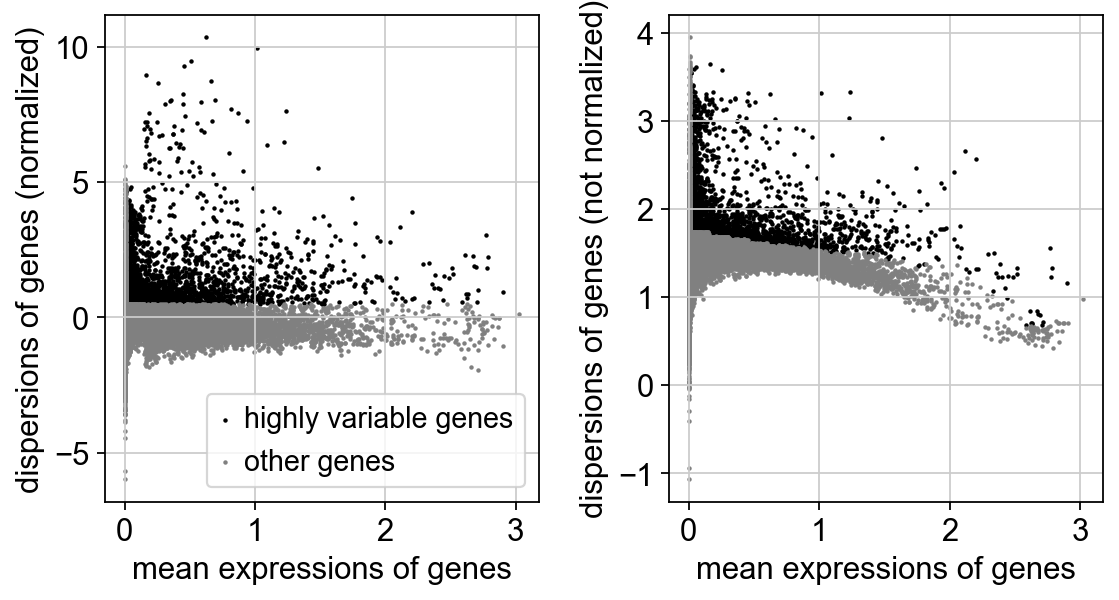

In [4]:
#| label: hvg
# compute variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
print("Highly variable genes: %d"%sum(adata.var.highly_variable))

#plot variable genes
sc.pl.highly_variable_genes(adata)

# subset for variable genes in the dataset
adata = adata[:, adata.var['highly_variable']]

## Z-score transformation

Now that the genes have been selected, we now proceed with PCA. Since
each gene has a different expression level, it means that genes with
higher expression values will naturally have higher variation that will
be captured by PCA. This means that we need to somehow give each gene a
similar weight when performing PCA (see below). The common practice is
to center and scale each gene before performing PCA. This exact scaling
called Z-score normalization is very useful for PCA, clustering and
plotting heatmaps. Additionally, we can use regression to remove any
unwanted sources of variation from the dataset, such as `cell cycle`,
`sequencing depth`, `percent mitochondria` etc. This is achieved by
doing a generalized linear regression using these parameters as
co-variates in the model. Then the residuals of the model are taken as
the *regressed data*. Although perhaps not in the best way, batch effect
regression can also be done here. By default, variables are scaled in
the PCA step and is not done separately. But it could be achieved by
running the commands below:

In [5]:
#| label: scale
#run this line if you get the "AttributeError: swapaxes not found" 
# adata = adata.copy()

# regress out unwanted variables
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# scale data, clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:00)


## PCA

Performing PCA has many useful applications and interpretations, which
much depends on the data used. In the case of single-cell data, we want
to segregate samples based on gene expression patterns in the data.

To run PCA, you can use the function `pca()`.

## CN note: PCA

Based on this plot, we can see that the top 8 PCs retain a lot of information, while other PCs contain progressively less. However, it is still advisable to use more PCs since they might contain information about rare cell types (such as platelets and DCs in this dataset)
从该图可以看出，前 8 个 PC 保留了大量信息，而其他 PC 保留的信息则逐渐减少。然而，仍然建议使用更多 PC，因为它们可能包含有关稀有细胞类型的信息（例如此数据集中的血小板和树突状细胞）。


In [6]:
#| label: pca
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:01)


We then plot the first principal components.

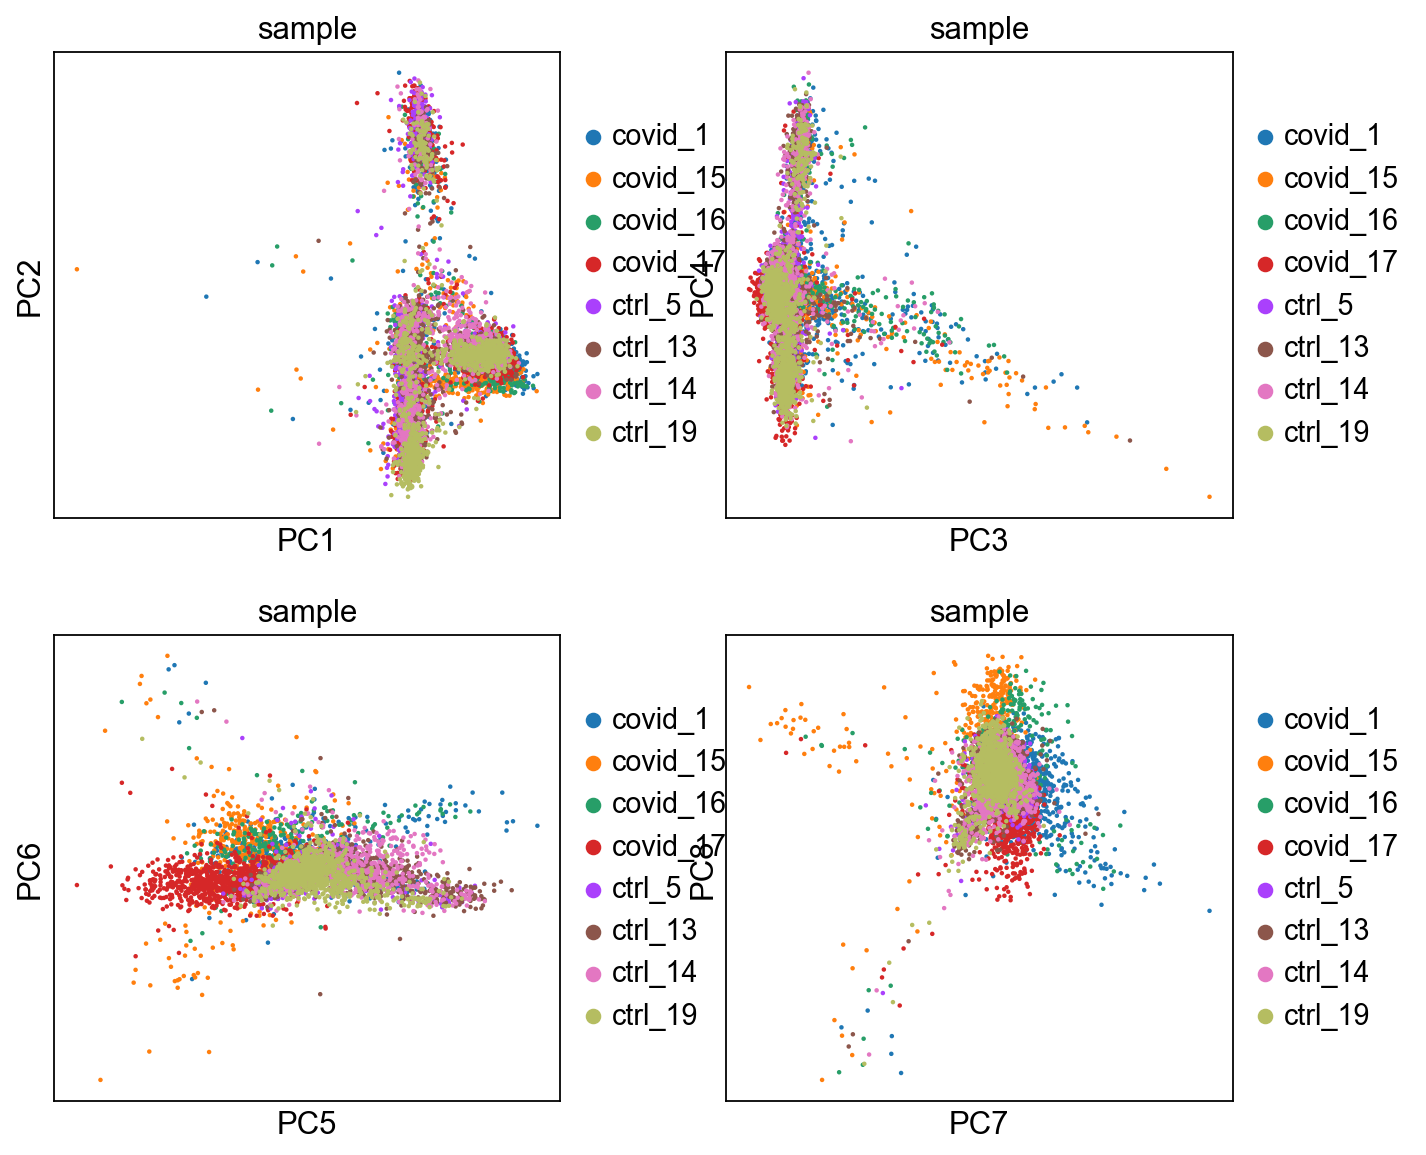

In [7]:
#| label: pca-plot
# plot more PCS
sc.pl.pca(adata, color='sample', components = ['1,2','3,4','5,6','7,8'], ncols=2)

To identify genes that contribute most to each PC, one can retrieve the
loading matrix information.

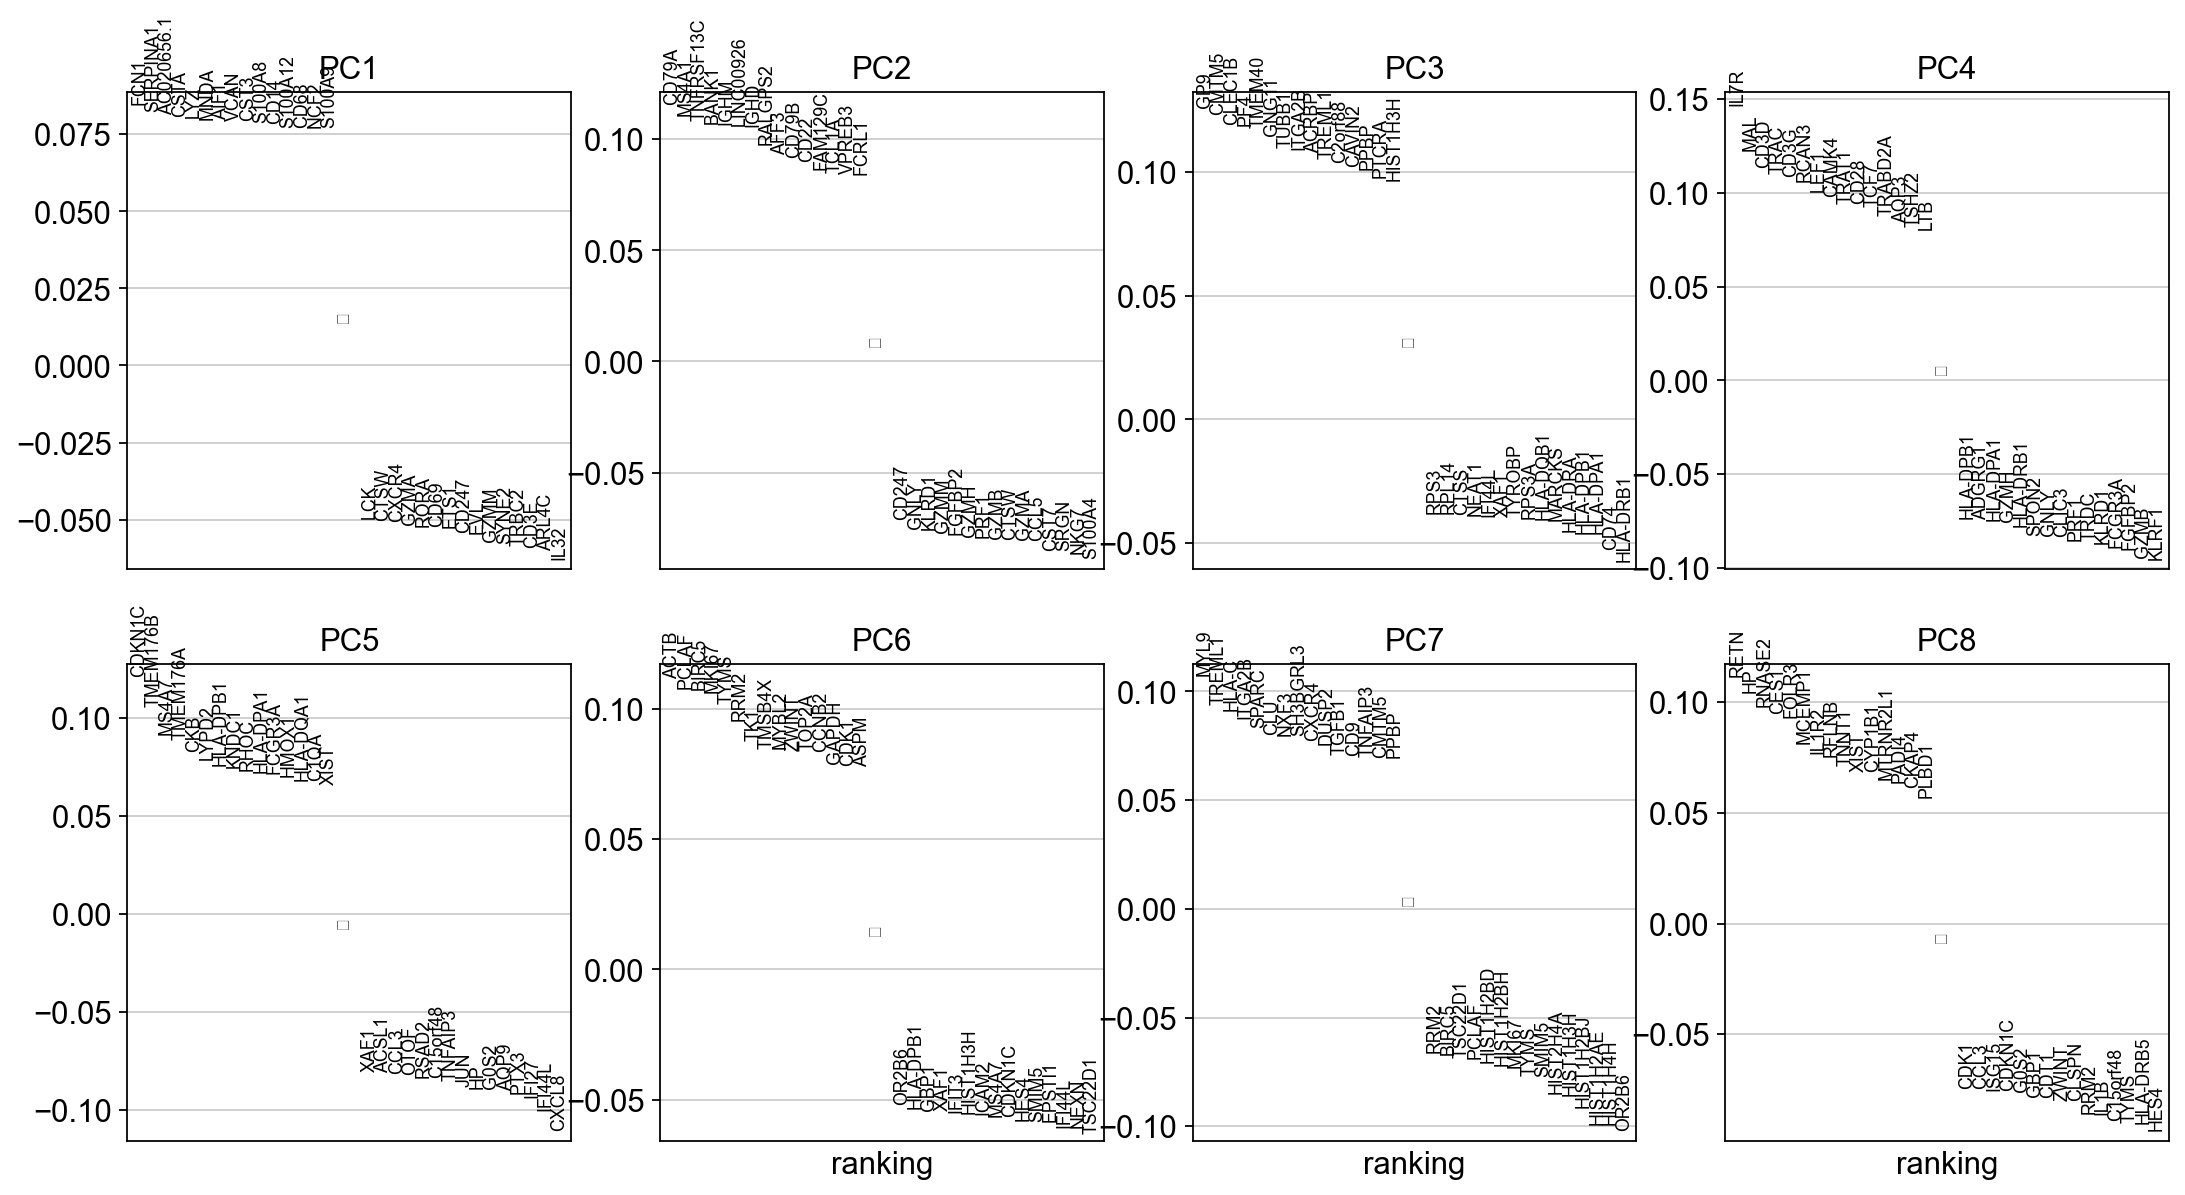

In [8]:
#| label: pca-loadings
#Plot loadings
sc.pl.pca_loadings(adata, components=[1,2,3,4,5,6,7,8])

# OBS! only plots the positive axes genes from each PC!!

The function to plot loading genes only plots genes on the positive
axes. Instead plot as a heatmaps, with genes on both positive and
negative side, one per pc, and plot their expression amongst cells
ordered by their position along the pc.

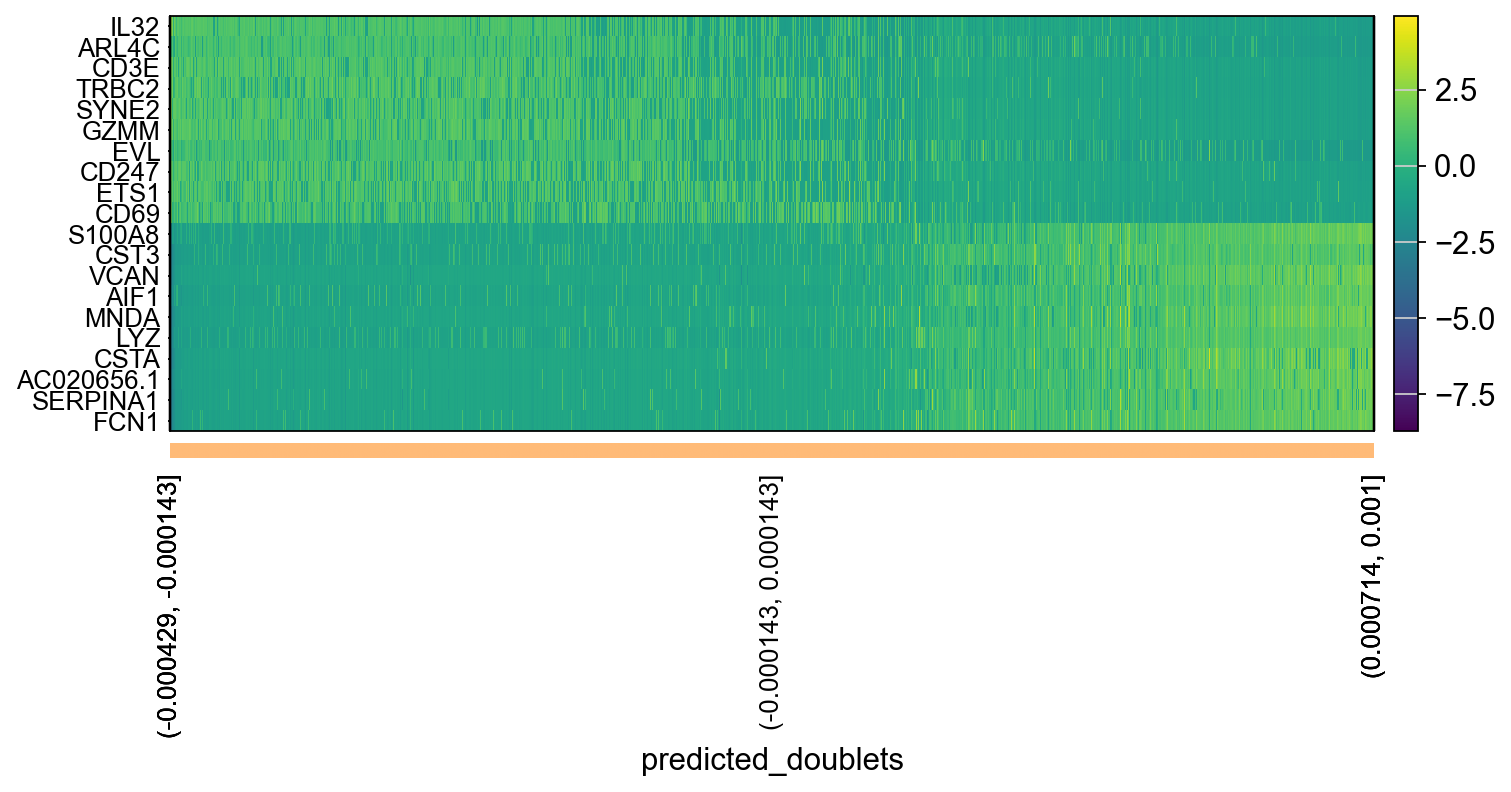

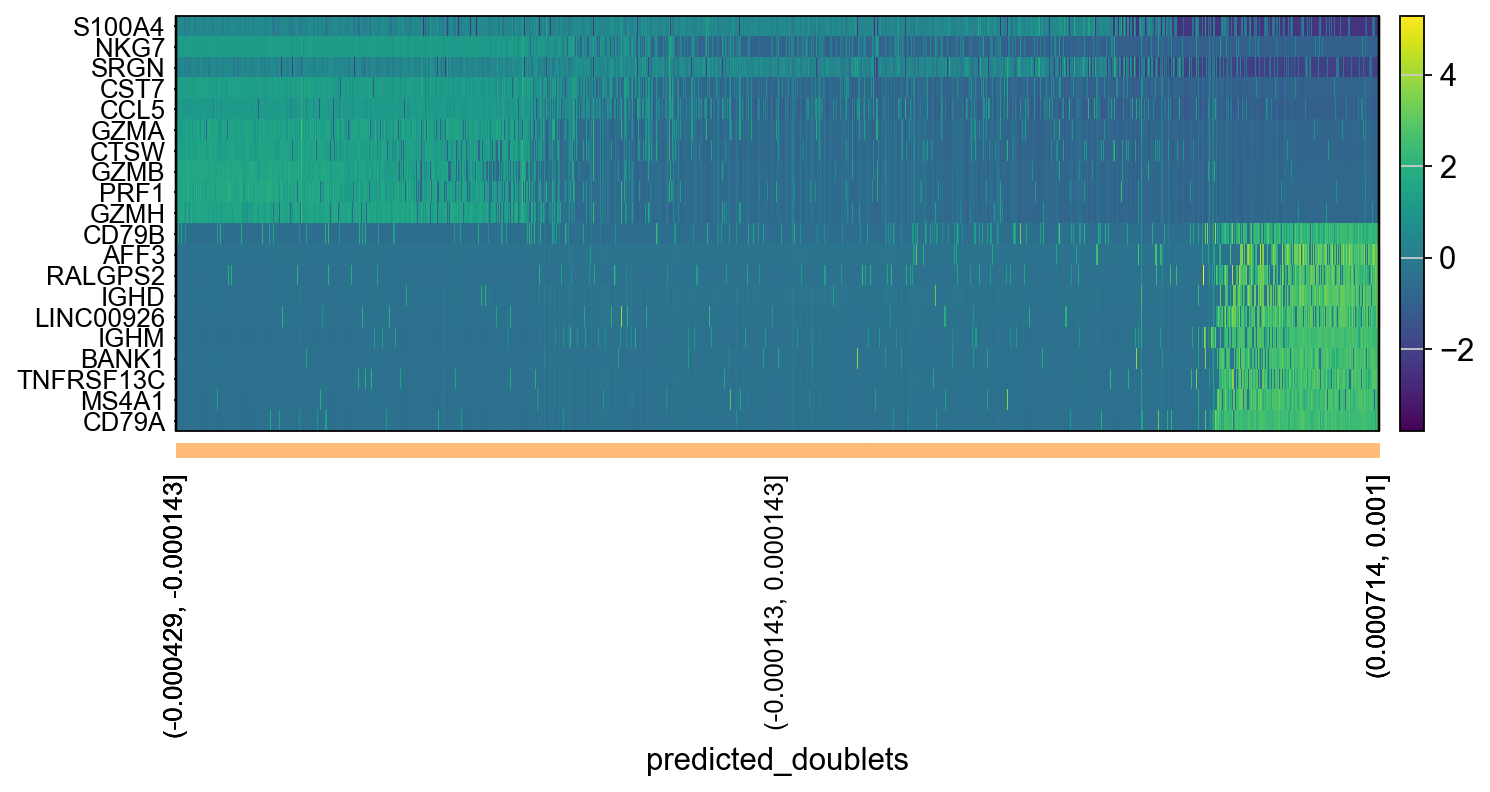

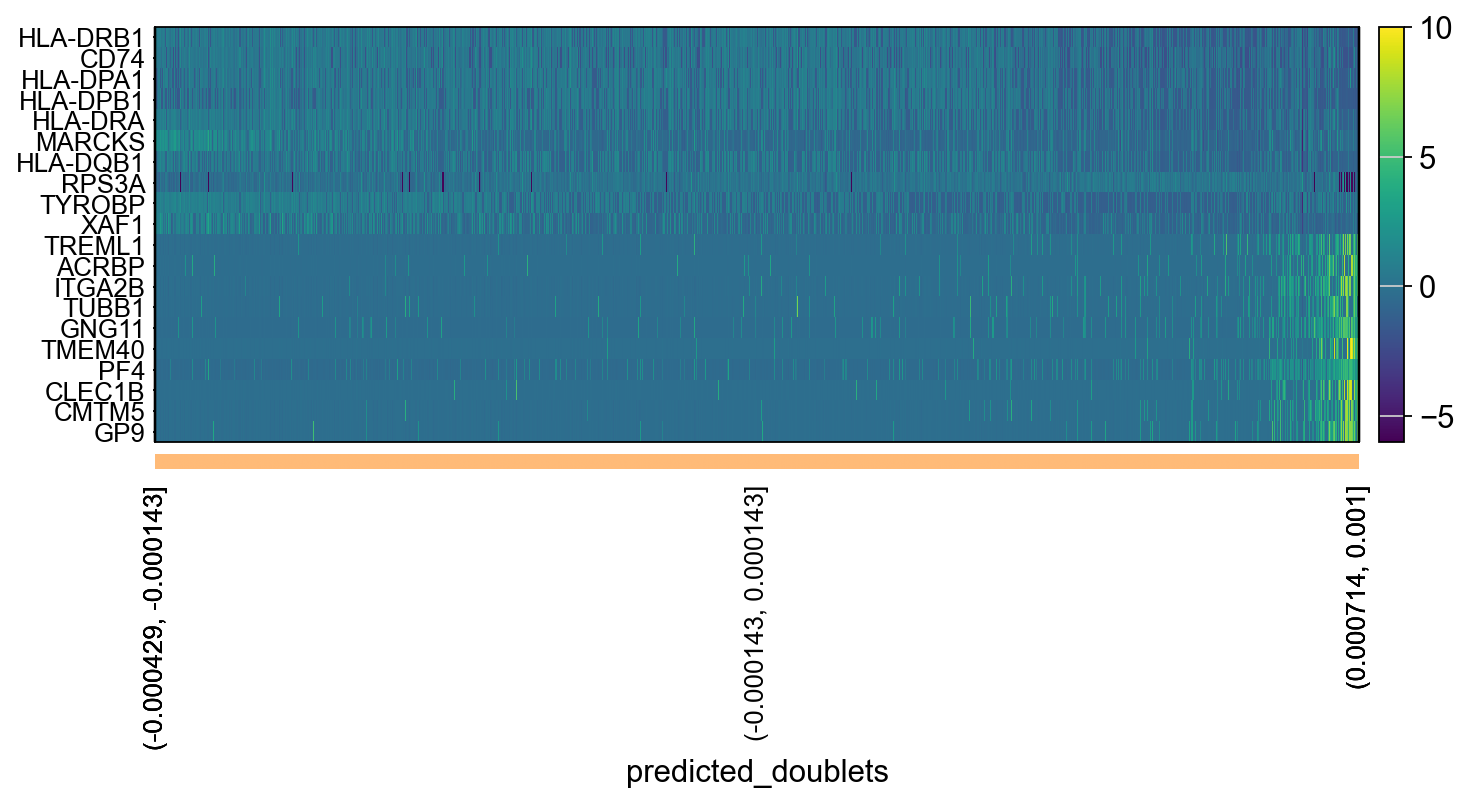

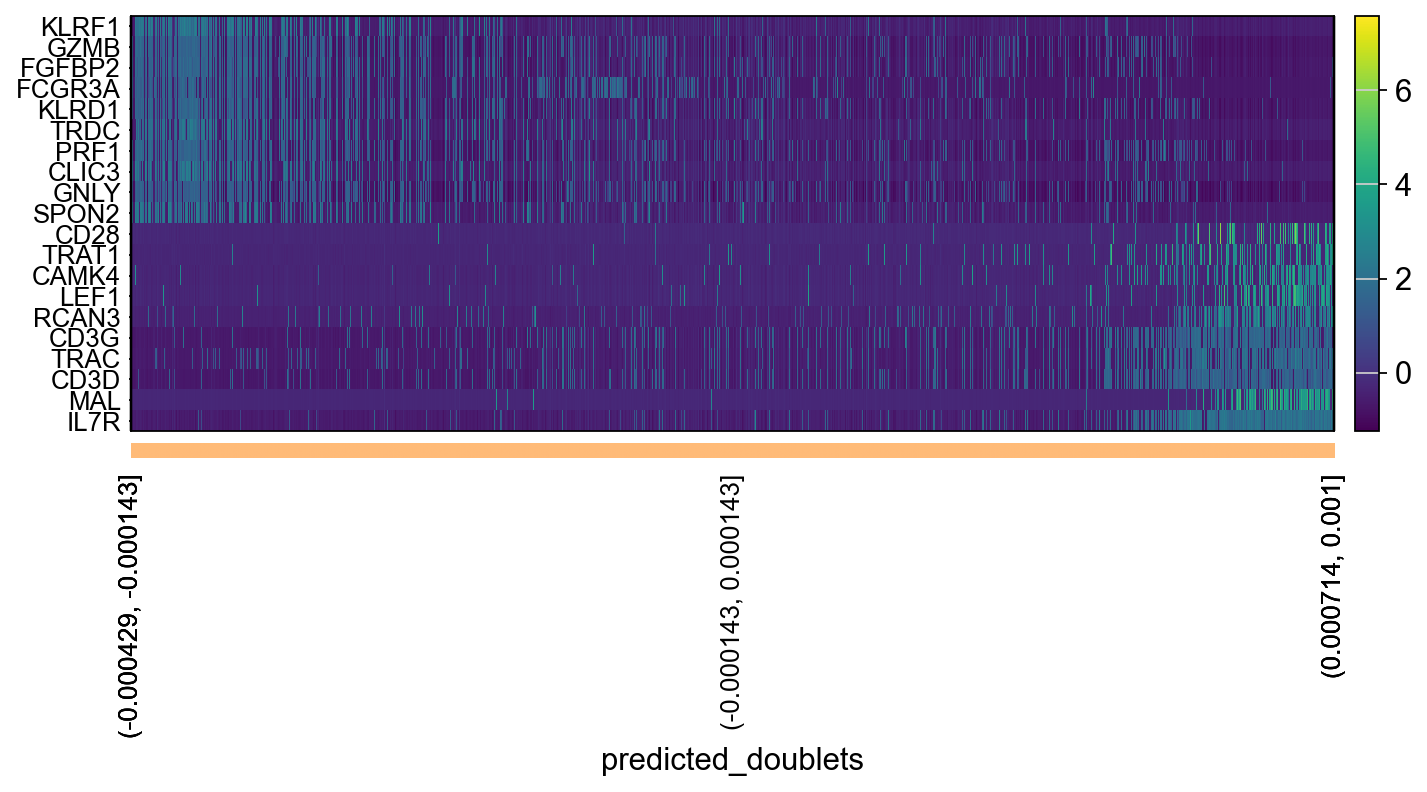

In [9]:
#| label: pca-loadings-heatmap
# adata.obsm["X_pca"] is the embeddings
# adata.uns["pca"] is pc variance
# adata.varm['PCs'] is the loadings

genes = adata.var['gene_ids']

for pc in [1,2,3,4]:
    g = adata.varm['PCs'][:,pc-1]
    o = np.argsort(g)
    sel = np.concatenate((o[:10],o[-10:])).tolist()
    emb = adata.obsm['X_pca'][:,pc-1]
    # order by position on that pc
    tempdata = adata[np.argsort(emb),]
    sc.pl.heatmap(tempdata, var_names = genes[sel].index.tolist(), groupby='predicted_doublets', swap_axes = True, use_raw=False)

We can also plot the amount of variance explained by each PC.

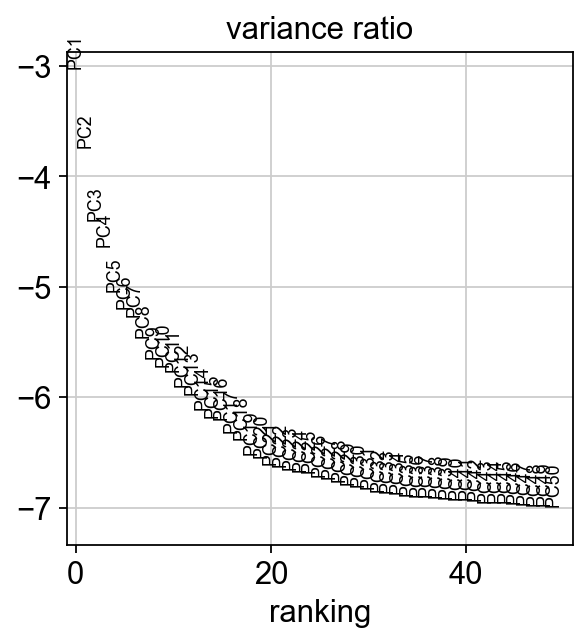

In [10]:
#| label: pca-elbow
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

Based on this plot, we can see that the top 8 PCs retain a lot of
information, while other PCs contain progressively less. However, it is
still advisable to use more PCs since they might contain information
about rare cell types (such as platelets and DCs in this dataset)

## tSNE

We will now run [BH-tSNE](https://arxiv.org/abs/1301.3342).

In [11]:
#| label: tsne
sc.tl.tsne(adata, n_pcs = 30)

computing tSNE
    using 'X_pca' with n_pcs = 30
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm)
    'tsne', tSNE parameters (adata.uns) (0:00:11)


We plot the tSNE scatterplot colored by dataset. We can clearly see the
effect of batches present in the dataset.

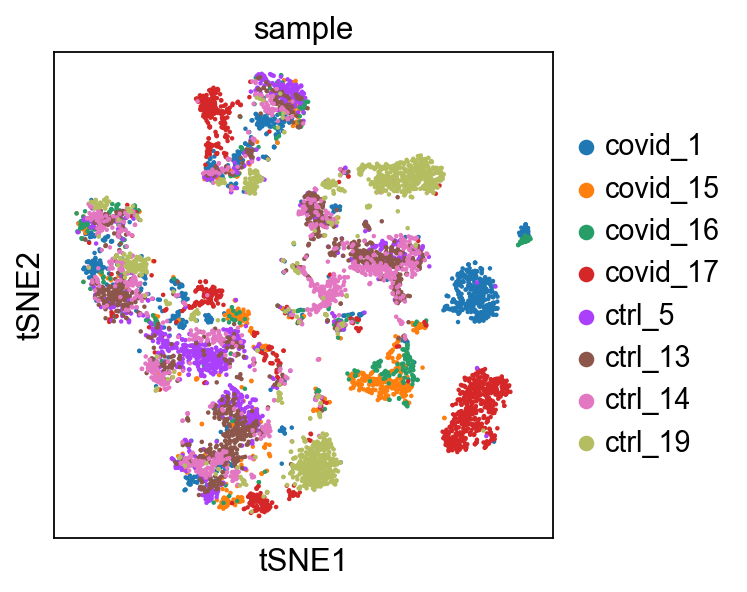

In [12]:
#| label: tsne-plot
sc.pl.tsne(adata, color='sample')

## CN note: tSNE

We plot the tSNE scatterplot colored by dataset. We can clearly see the effect of batches present in the dataset.

重要的点是如何鉴定和发现批次效应/effect of batches


## UMAP

The UMAP implementation in SCANPY uses a neighborhood graph as the
distance matrix, so we need to first calculate the graph.

## CN note: UMAP

- 依然是批次效应的影响
- 会在下一步**Data Integration**中解决


In [13]:
#| label: neighbors
sc.pp.neighbors(adata, n_pcs = 30, n_neighbors = 20)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


We can now run [UMAP](https://arxiv.org/abs/1802.03426) for cell
embeddings.

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:05)


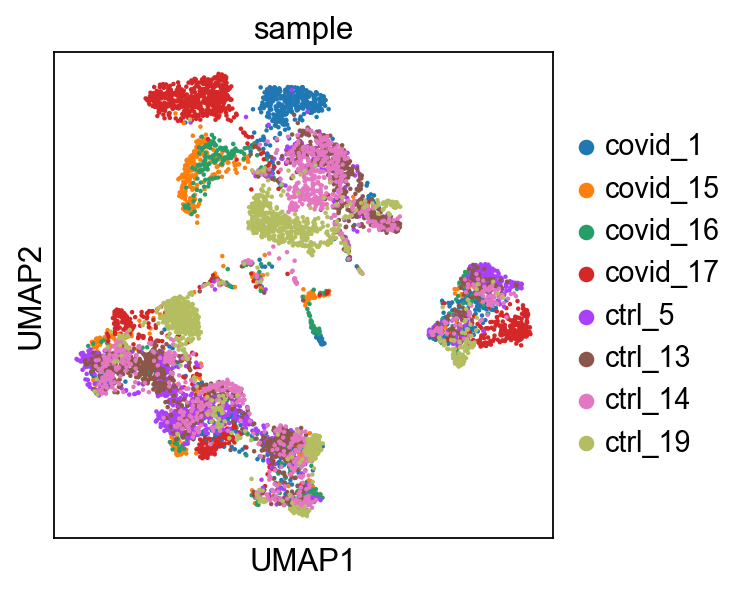

In [14]:
#| label: umap
sc.tl.umap(adata)
sc.pl.umap(adata, color='sample')

UMAP is plotted colored per dataset. Although less distinct as in the
tSNE, we still see quite an effect of the different batches in the data.

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:06)


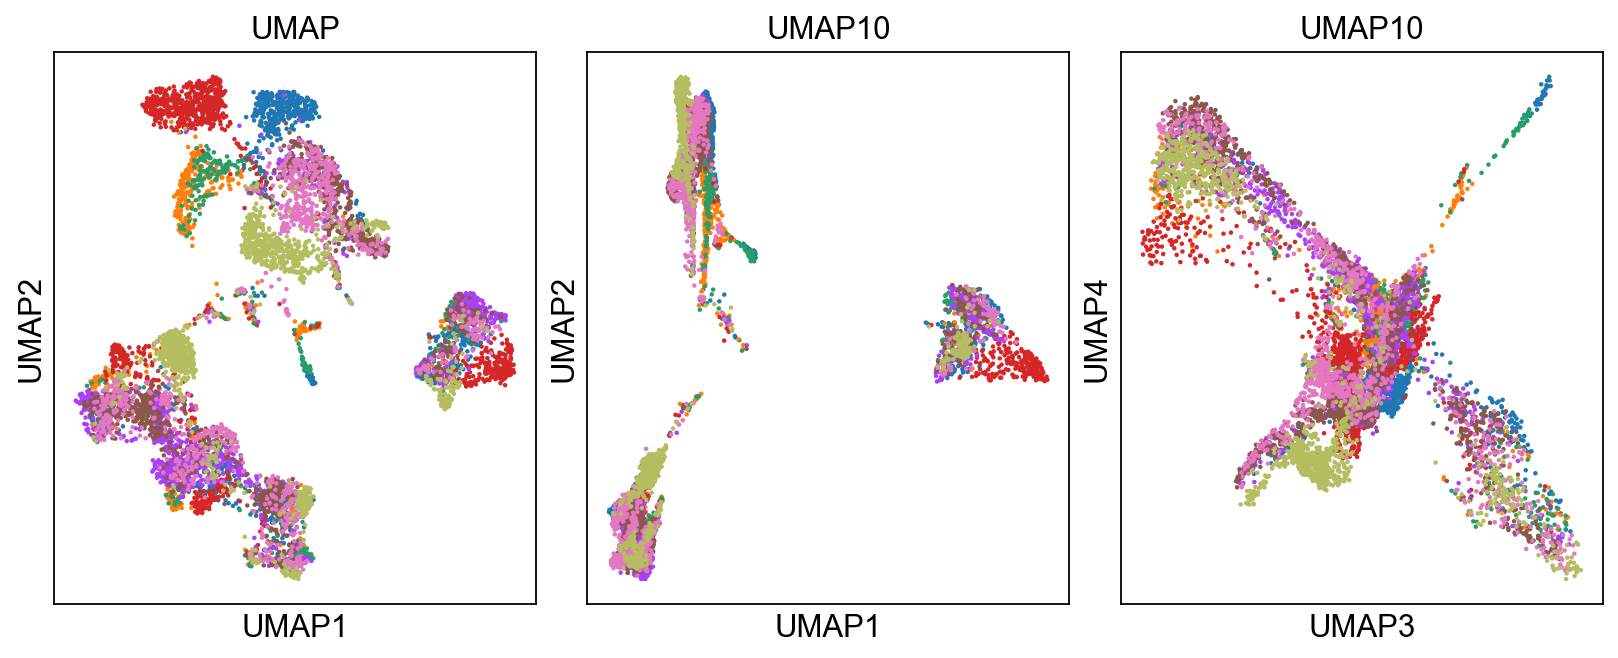

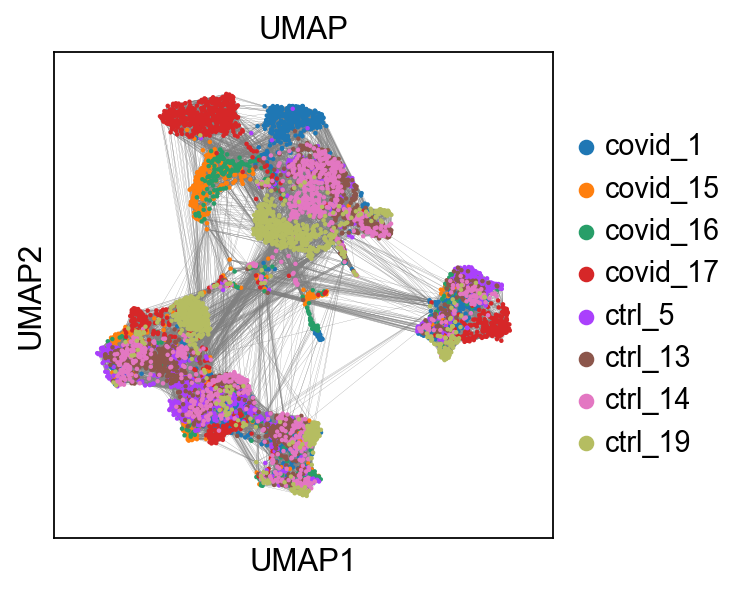

In [15]:
#| label: umap10
# run with 10 components, save to a new object so that the umap with 2D is not overwritten.
umap10 = sc.tl.umap(adata, n_components=10, copy=True)
fig, axs = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)

sc.pl.umap(adata, color='sample',  title="UMAP",
           show=False, ax=axs[0], legend_loc=None)
sc.pl.umap(umap10, color='sample', title="UMAP10", show=False,
           ax=axs[1], components=['1,2'], legend_loc=None)
sc.pl.umap(umap10, color='sample', title="UMAP10",
           show=False, ax=axs[2], components=['3,4'], legend_loc=None)

# we can also plot the umap with neighbor edges
sc.pl.umap(adata, color='sample', title="UMAP", edges=True)

We can now plot PCA, UMAP and tSNE side by side for comparison. Have a
look at the UMAP and tSNE. What similarities/differences do you see? Can
you explain the differences based on what you learned during the
lecture? Also, we can conclude from the dimensionality reductions that
our dataset contains a batch effect that needs to be corrected before
proceeding to clustering and differential gene expression analysis.

<Axes: title={'center': 'sample'}, xlabel='UMAP1', ylabel='UMAP2'>

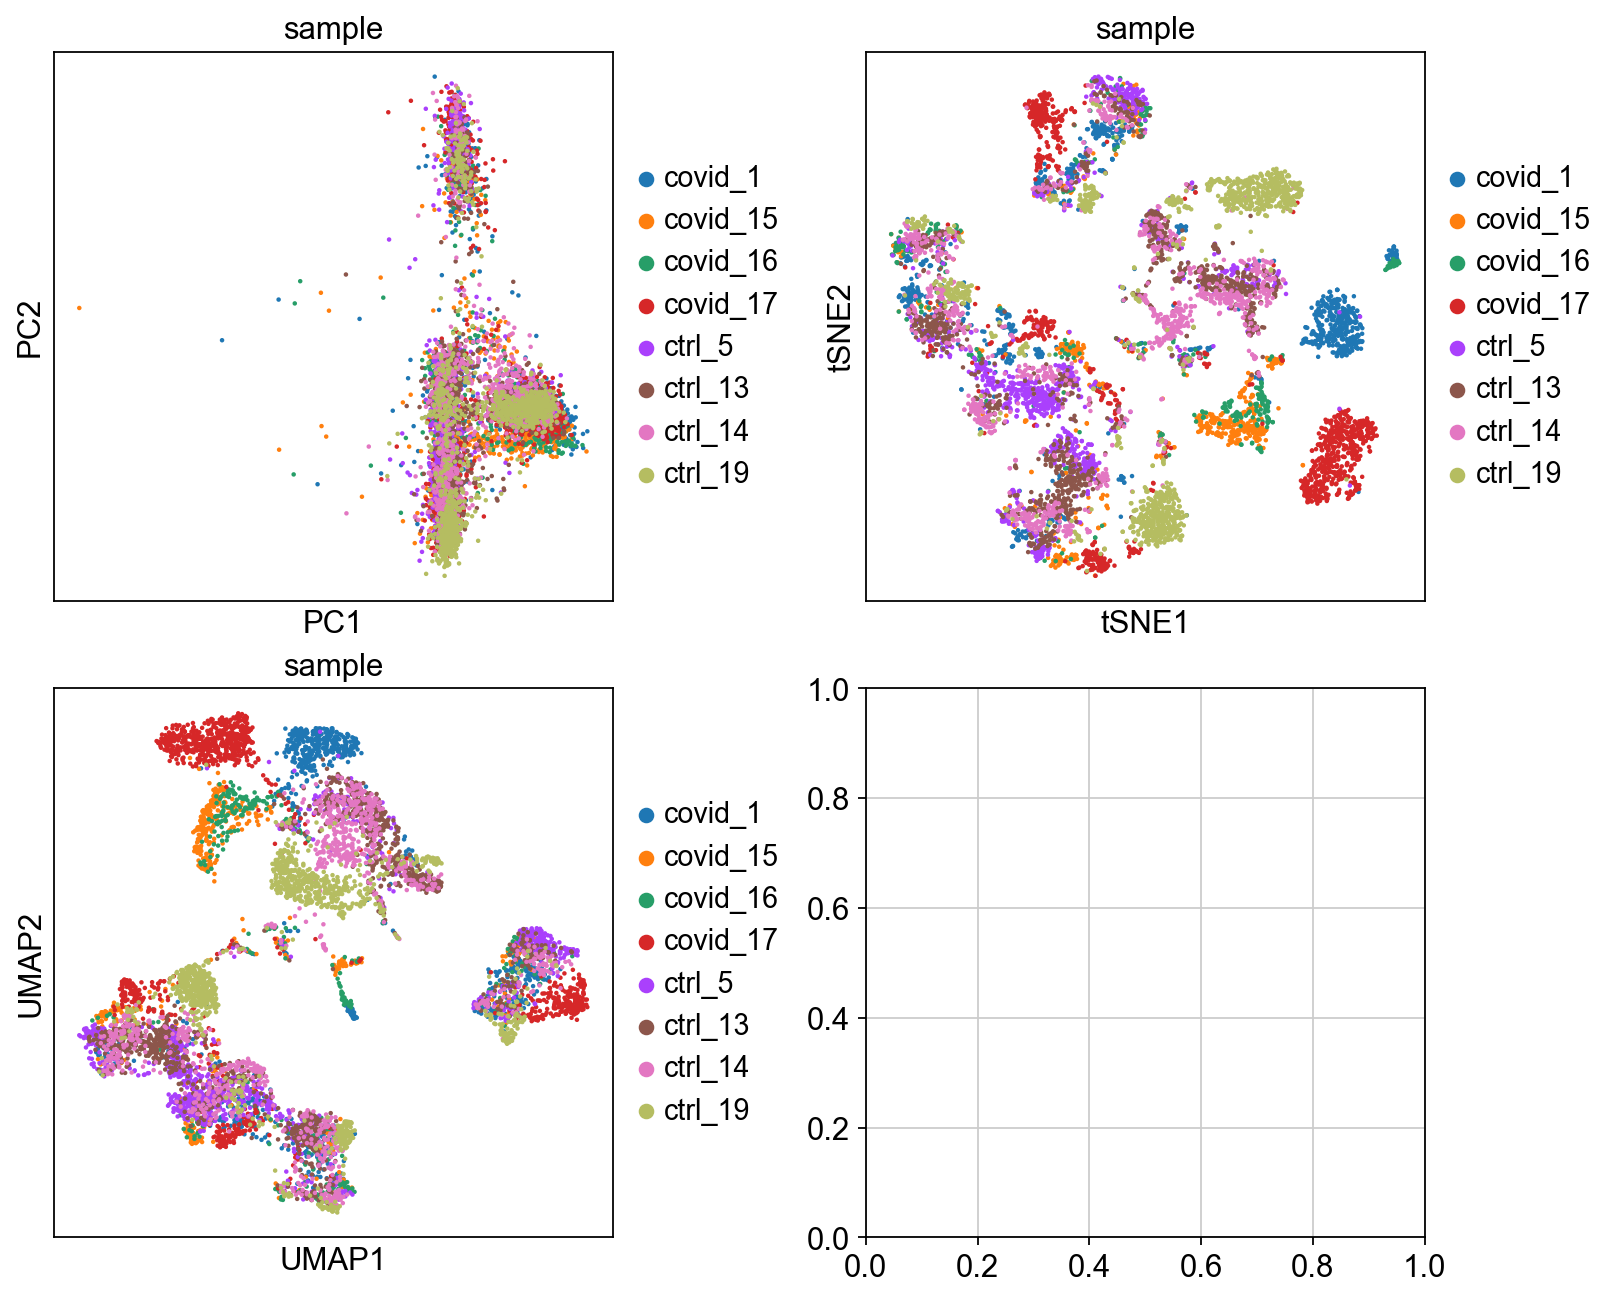

In [16]:
#| label: plot-all
fig, axs = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
sc.pl.pca(adata, color='sample', components=['1,2'], ax=axs[0, 0], show=False)
sc.pl.tsne(adata, color='sample', components=['1,2'], ax=axs[0, 1], show=False)
sc.pl.umap(adata, color='sample', components=['1,2'], ax=axs[1, 0], show=False)

Finally, we can compare the PCA, tSNE and UMAP.

<div>

> **Discuss**
>
> We have now done Variable gene selection, PCA and UMAP with the
> settings we selected for you. Test a few different ways of selecting
> variable genes, number of PCs for UMAP and check how it influences
> your embedding.

</div>

## Genes of interest

Let's plot some marker genes for different cell types onto the
embedding.

  Markers                    Cell Type
  -------------------------- -------------------
  CD3E                       T cells
  CD3E CD4                   CD4+ T cells
  CD3E CD8A                  CD8+ T cells
  GNLY, NKG7                 NK cells
  MS4A1                      B cells
  CD14, LYZ, CST3, MS4A7     CD14+ Monocytes
  FCGR3A, LYZ, CST3, MS4A7   FCGR3A+ Monocytes
  FCER1A, CST3               DCs

## CN note: Genes of interest

- 只是看一下数据罢了，这里的细分群体因为批次效应，已经没什么意义了，随便看看

- The default is to plot gene expression in the normalized and log-transformed data. You can also plot it on the scaled and corrected data by using use_raw=False. However, not all of these genes are included in the variable gene set, and hence are not included in the scaled adata.X, so we first need to filter them.
- 默认设置是在标准化和对数转换后的数据中绘制基因表达图。你也可以使用 use_raw=False 将其绘制在缩放和校正后的数据上。然而，并非所有这些基因都包含在可变基因集中，因此它们不会包含在缩放后的 adata.X 中，所以我们首先需要对它们进行过滤。

**并且注意缩放后的数据和标准化后的数据的差异！！**


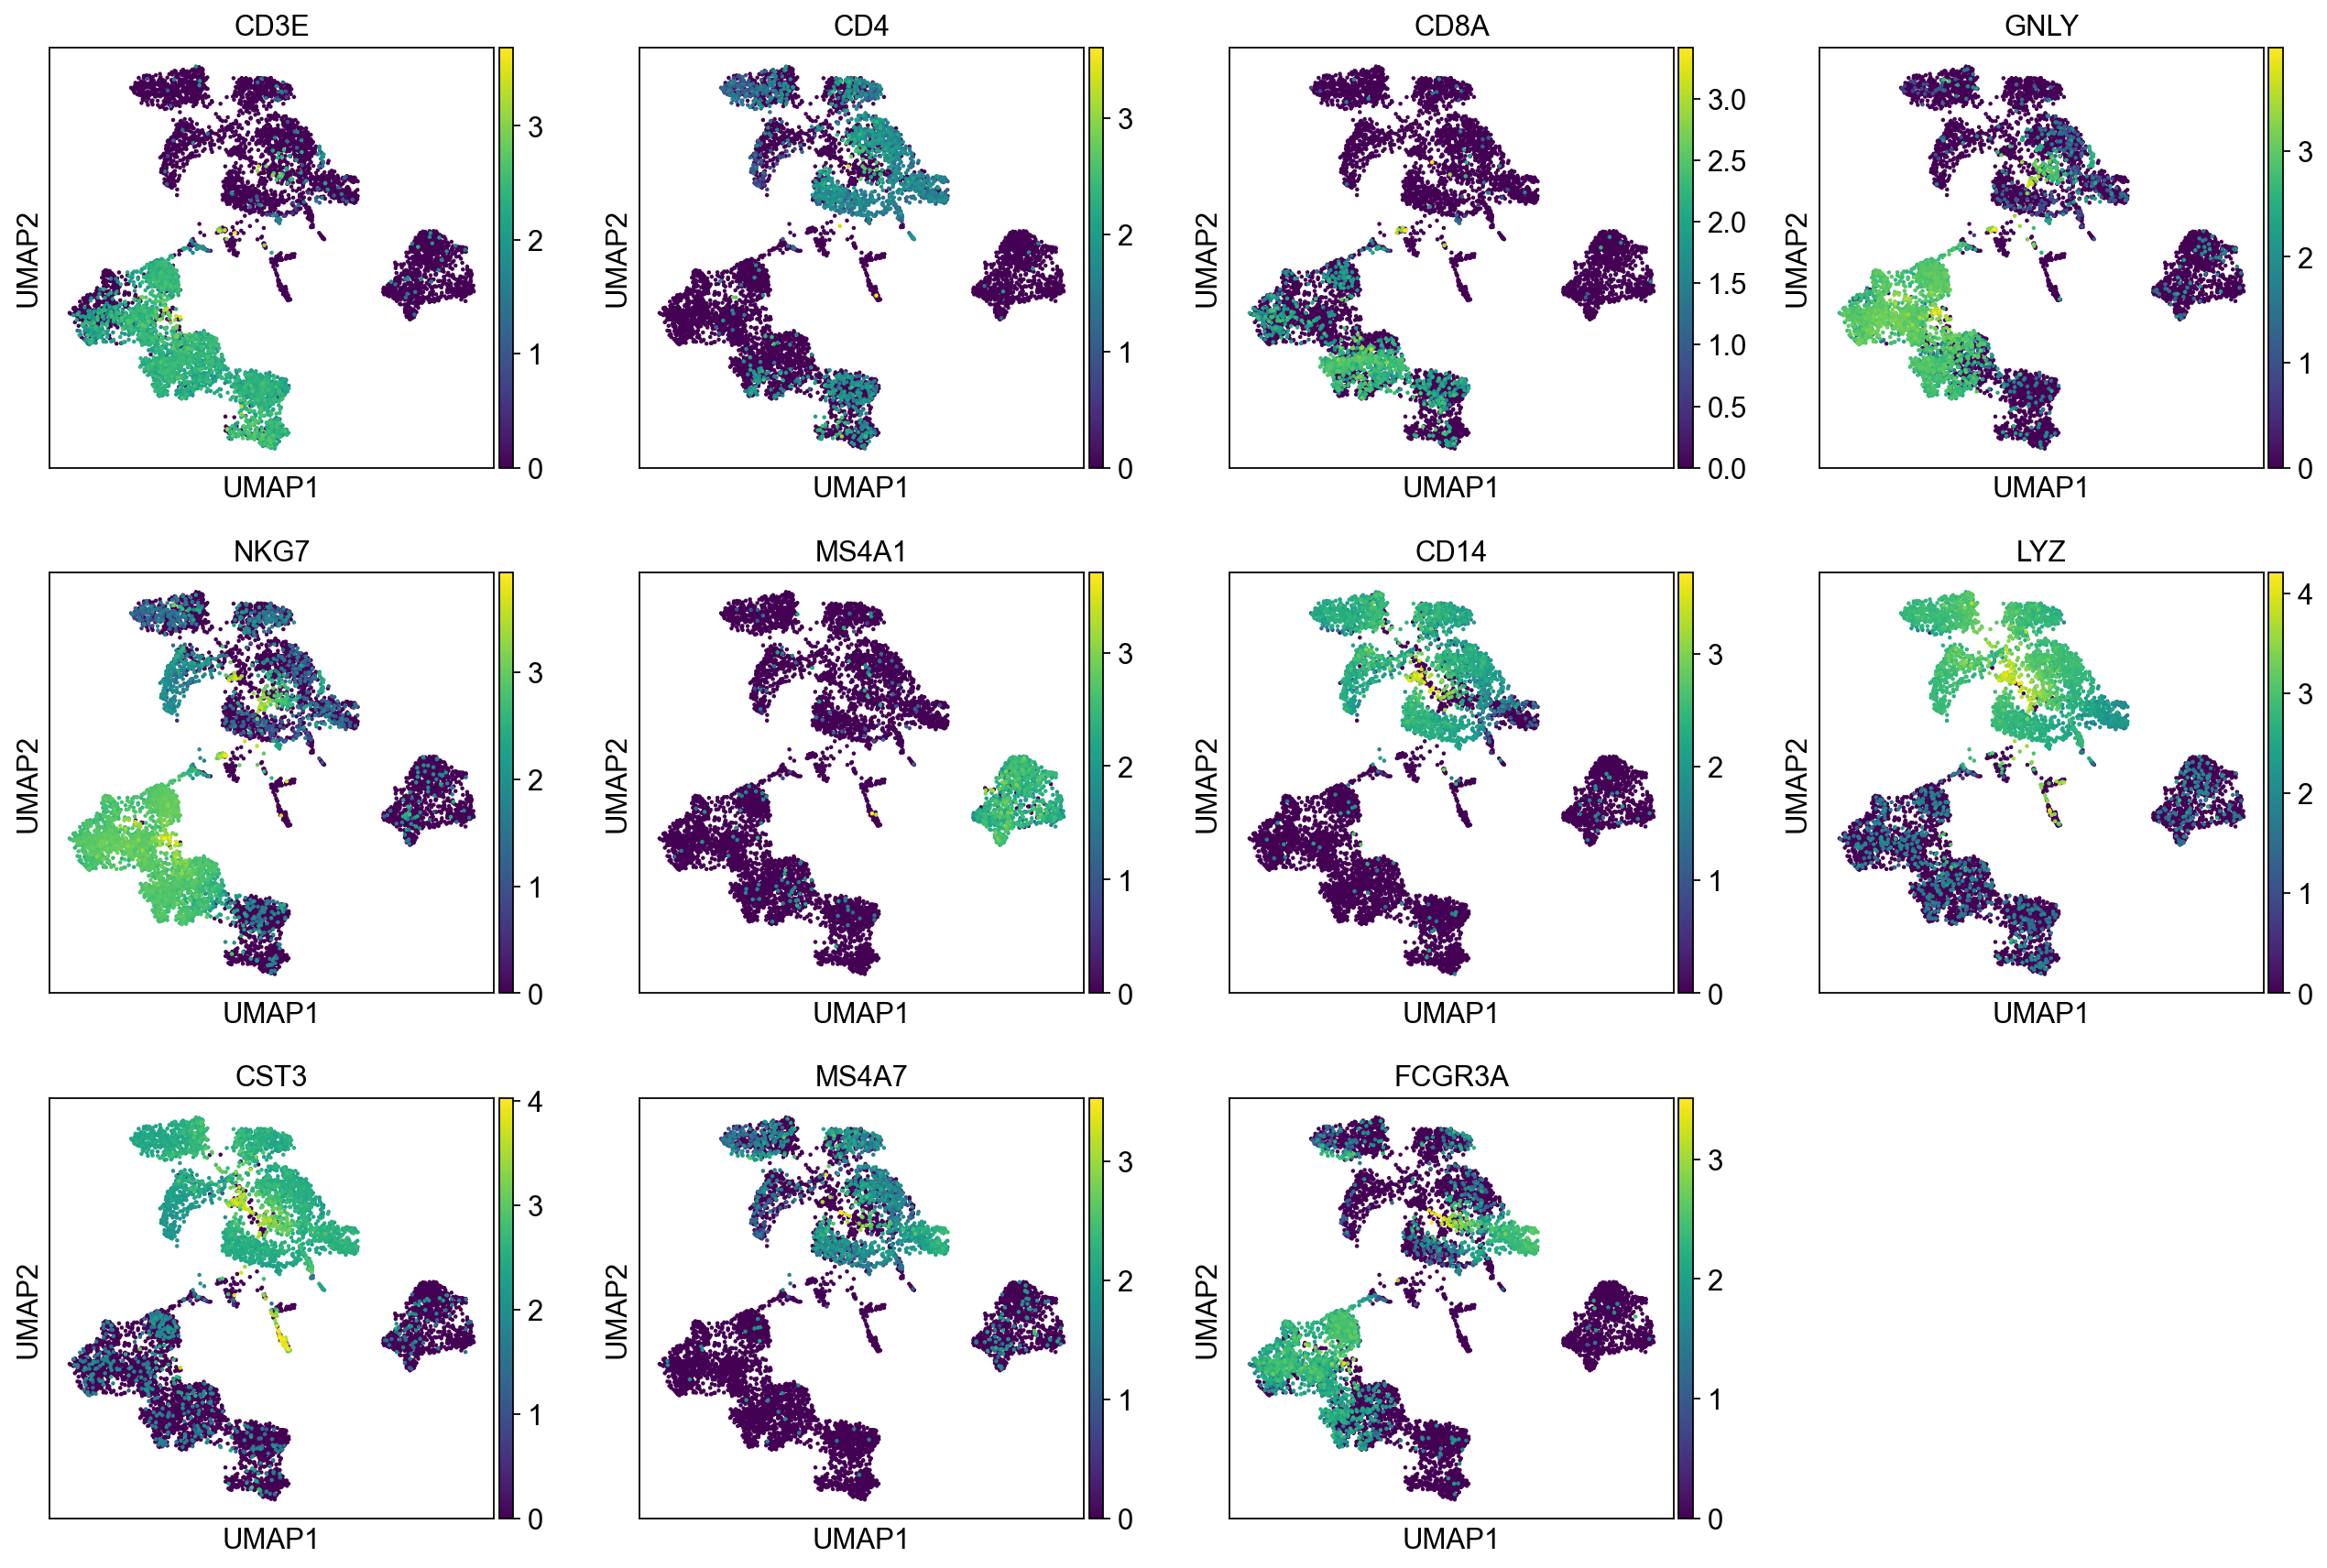

In [17]:
#| label: plot-markers
sc.pl.umap(adata, color=["CD3E", "CD4", "CD8A", "GNLY","NKG7", "MS4A1","CD14","LYZ","CST3","MS4A7","FCGR3A"])

### use_raw

The default is to plot gene expression in the normalized and
log-transformed data. You can also plot it on the scaled and corrected
data by using `use_raw=False`. However, not all of these genes are
included in the variable gene set, and hence are not included in the
scaled `adata.X`, so we first need to filter them.

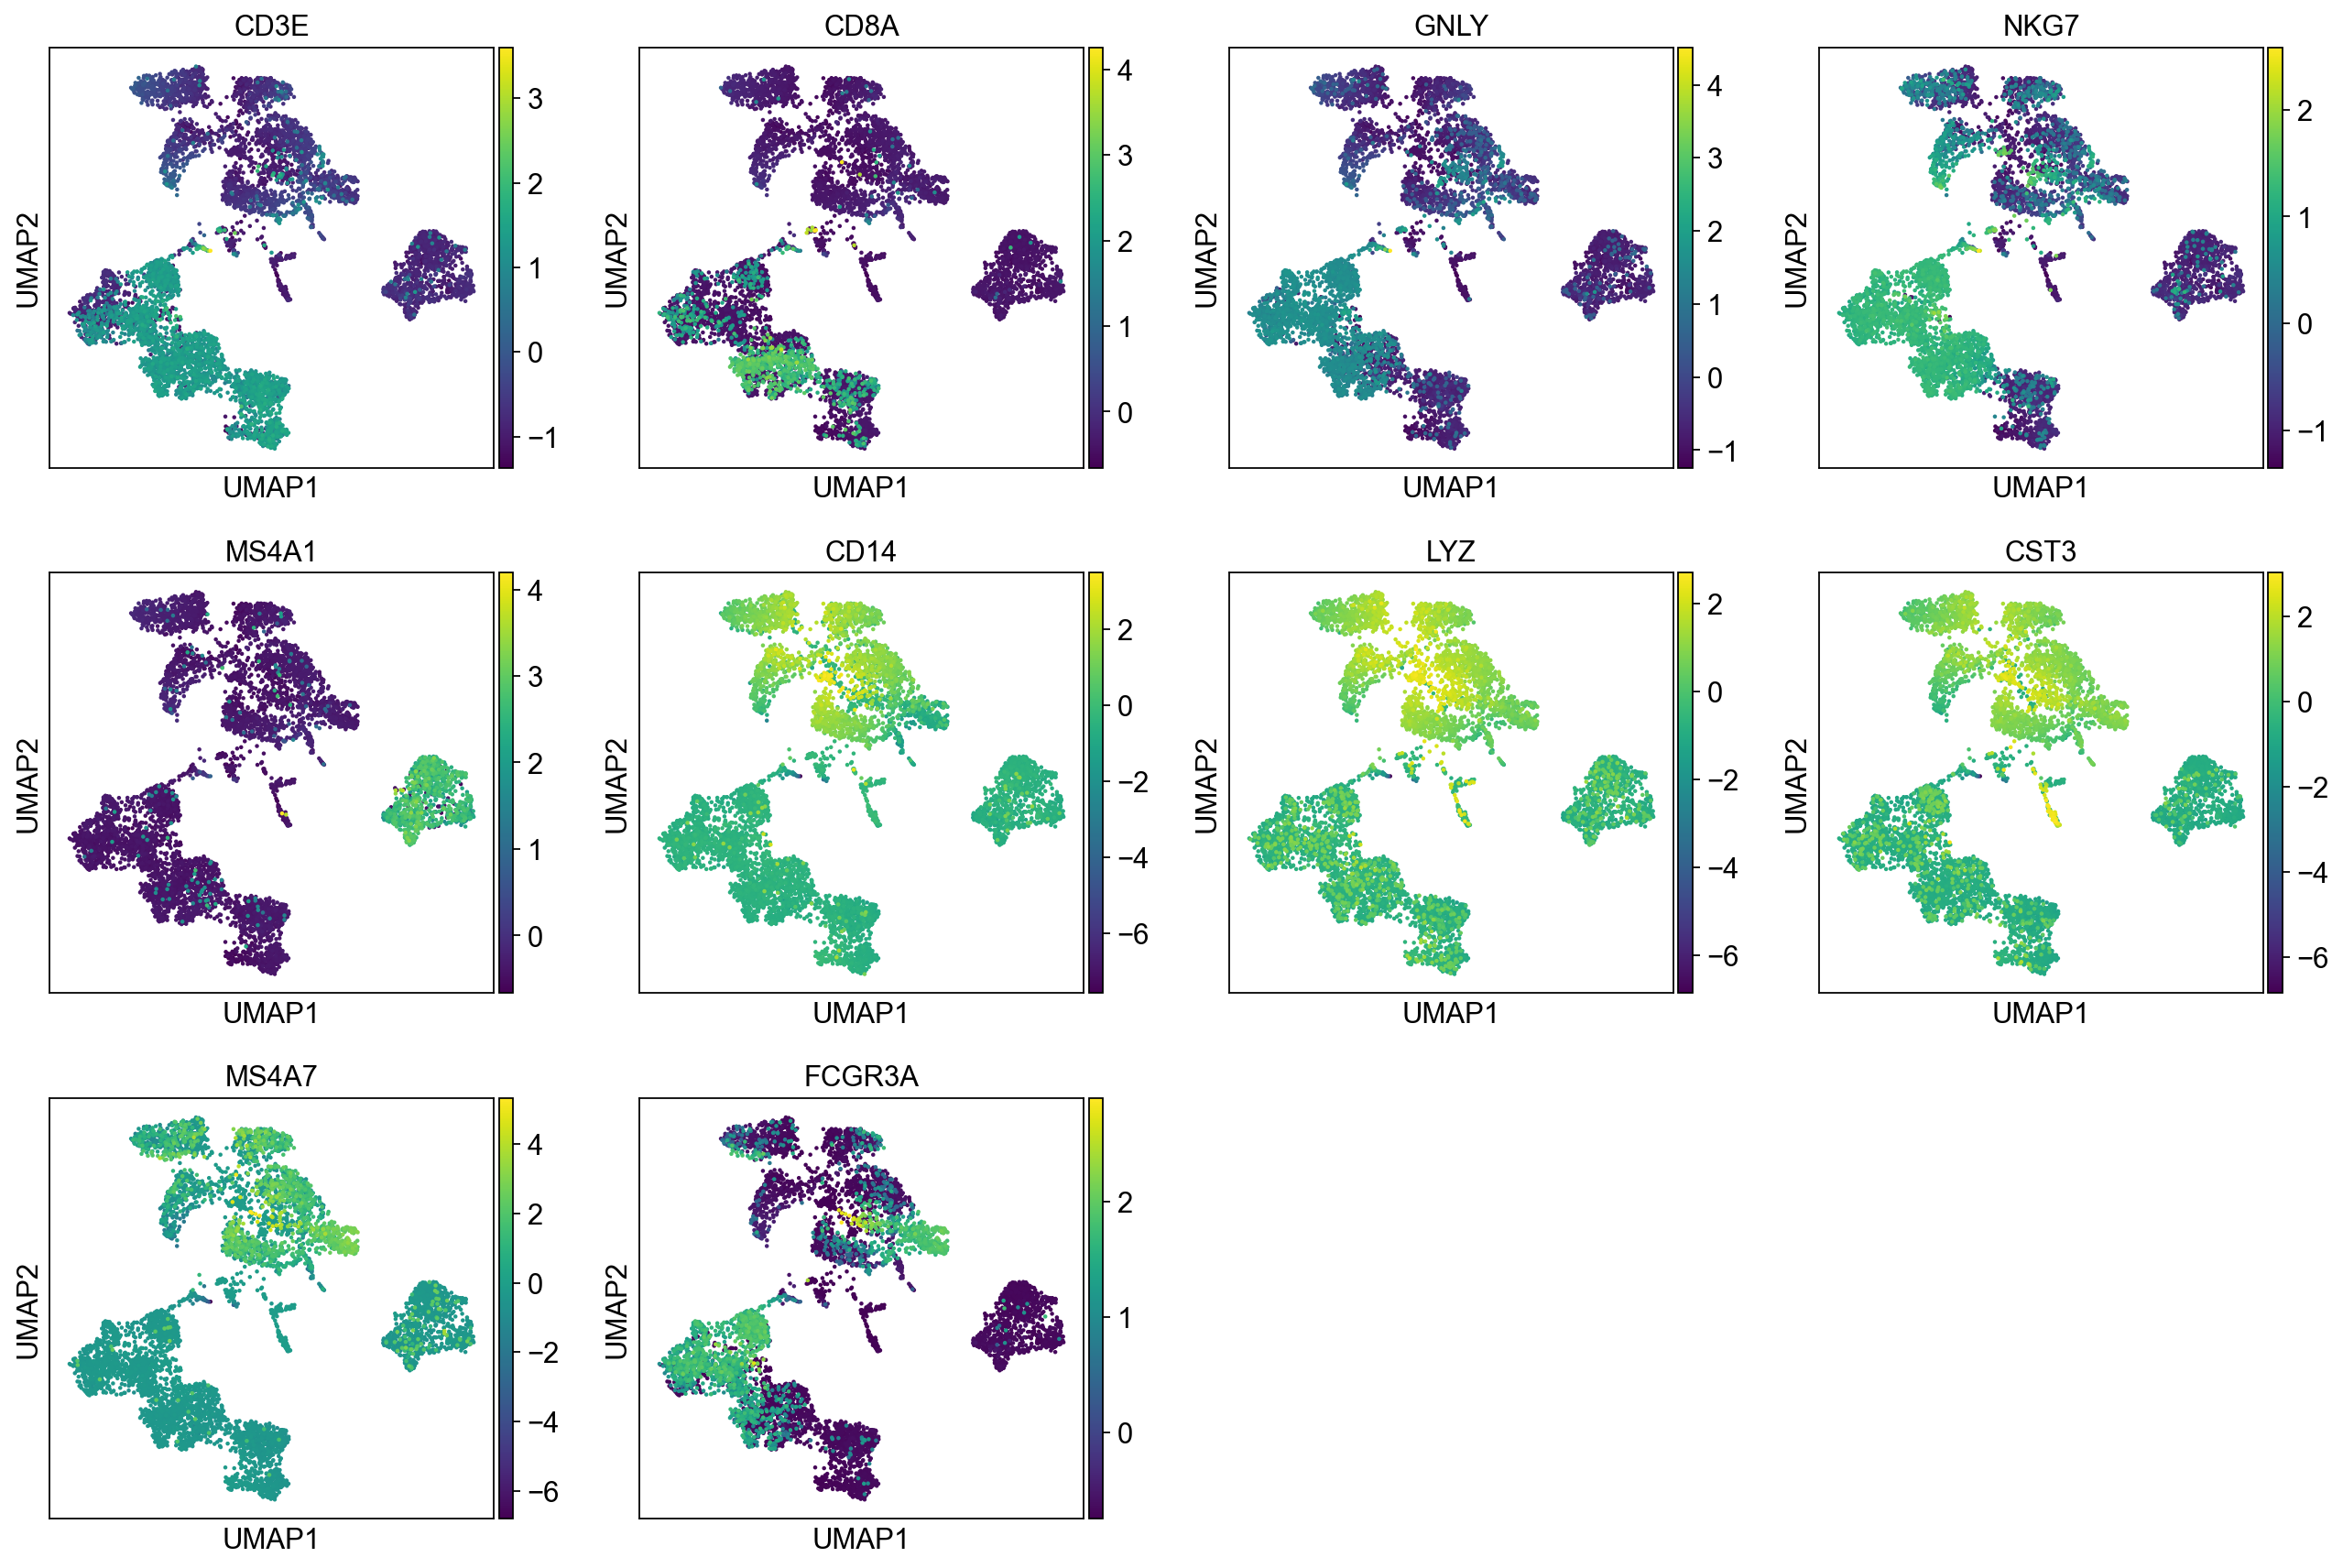

In [18]:
#| label: plot-markers2
genes  = ["CD3E", "CD4", "CD8A", "GNLY","NKG7", "MS4A1","CD14","LYZ","CST3","MS4A7","FCGR3A"]
var_genes = adata.var.highly_variable
var_genes.index[var_genes]
varg = [x for x in genes if x in var_genes.index[var_genes]]
sc.pl.umap(adata, color=varg, use_raw=False)

<div>

> **Discuss**
>
> Select some of your dimensionality reductions and plot some of the QC
> stats that were calculated in the previous lab. Can you see if some of
> the separation in your data is driven by quality of the cells?

</div>

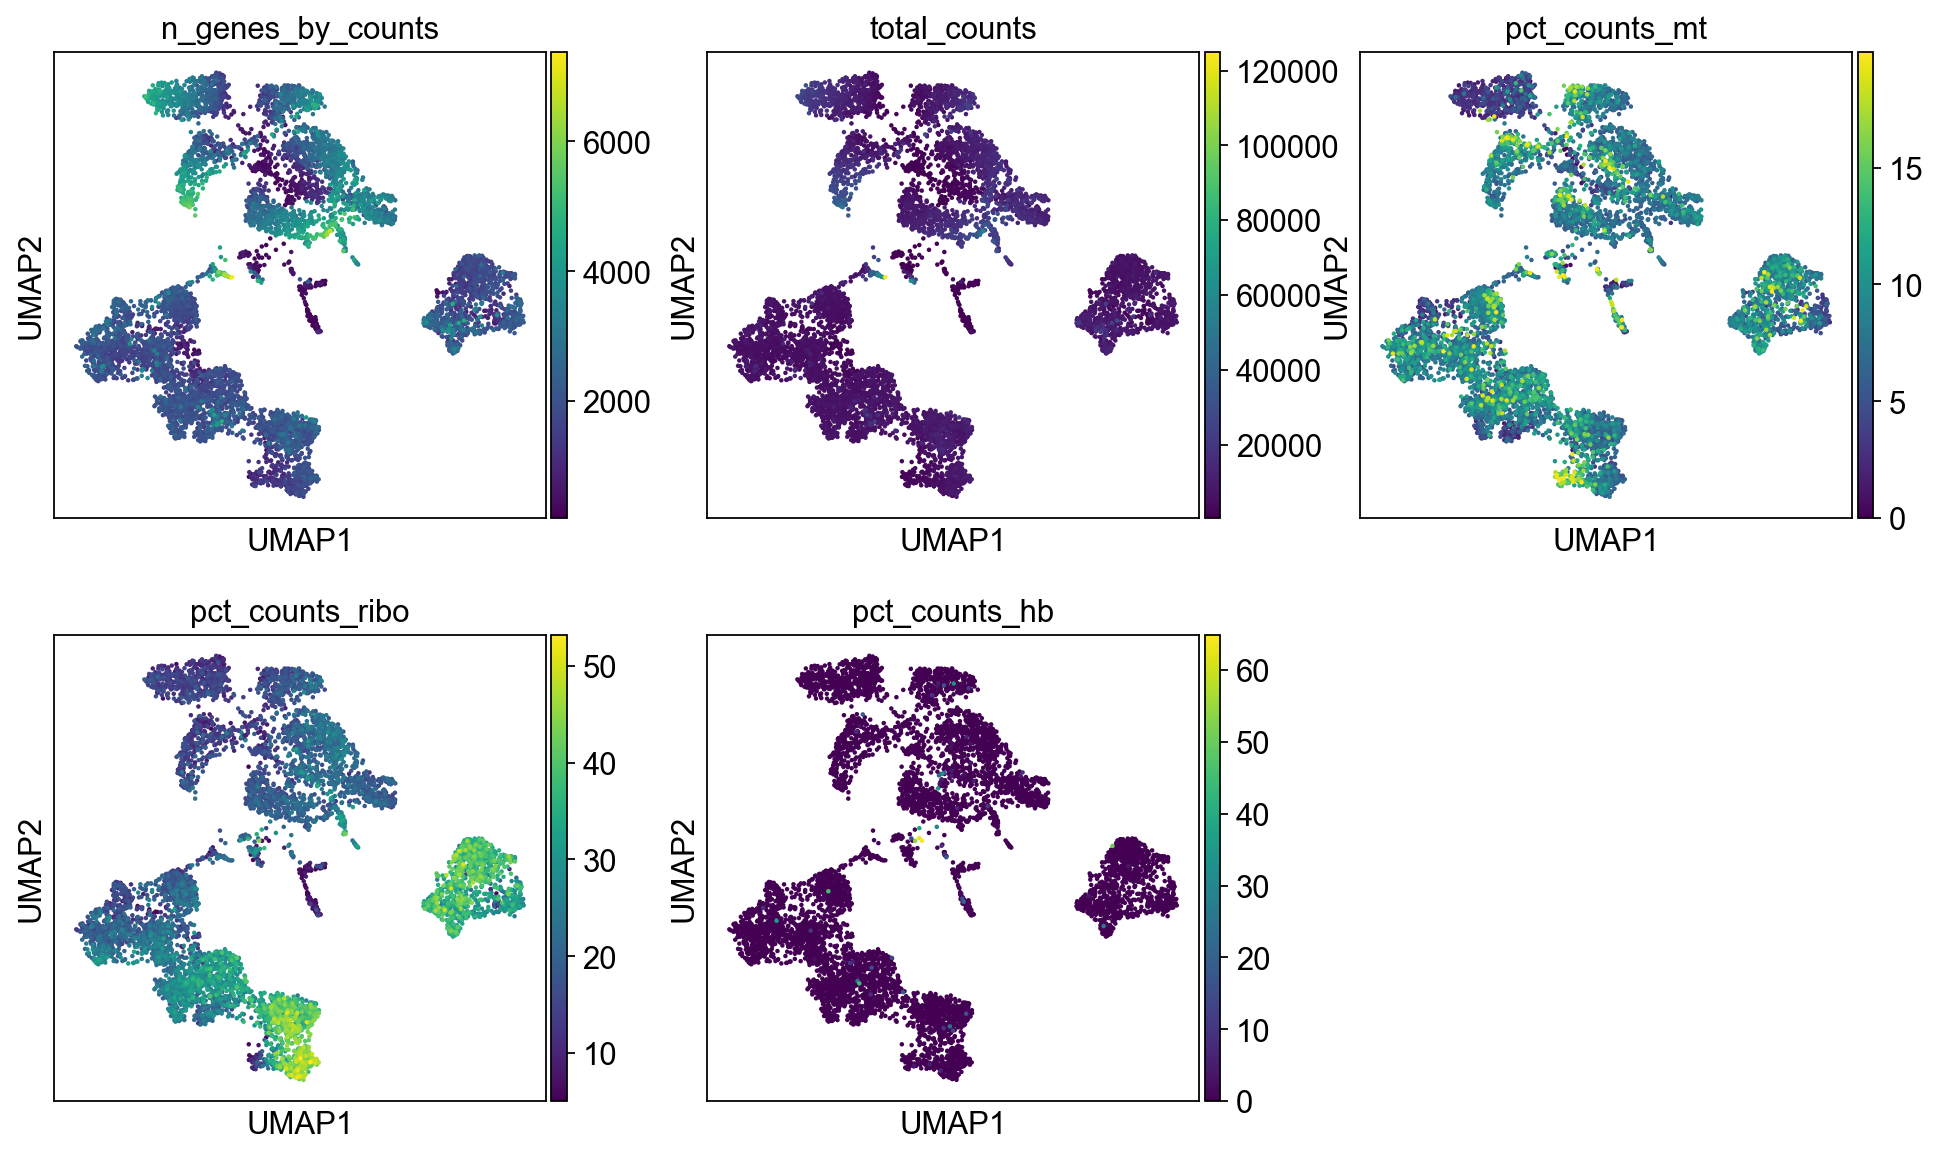

In [19]:
#| label: plot-qc
sc.pl.umap(adata, color=['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'], ncols=3,use_raw=False)

## Save data

We can finally save the object for use in future steps.

In [20]:
#| label: save
adata.write_h5ad('data/covid/results/scanpy_covid_qc_dr.h5ad')

## Note

Just as a reminder, you need to keep in mind what you have in the X
matrix. After these operations you have an X matrix with only variable
genes, that are normalized, logtransformed and scaled.

We stored the expression of all genes in `raw.X` after doing
lognormalization so that matrix is a sparse matrix with logtransformed
values.

In [21]:
#| label: check-data
print(adata.X.shape)
print(adata.raw.X.shape)

print(adata.X[:3,:3])
print(adata.raw.X[:10,:10])

(7332, 2656)
(7332, 19468)
[[-0.04097649 -0.04808595 -0.06951175]
 [-0.05810044 -0.11063513 -0.34450077]
 [-0.07079222 -0.13746446 -0.48150336]]
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (10, 10)>
  Coords	Values
  (1, 4)	1.479703103222477
  (8, 7)	1.6397408237842532


## Session info

```{=html}
<details>
```
```{=html}
<summary>
```
Click here
```{=html}
</summary>
```

In [22]:
#| label: session
sc.logging.print_versions()

matplotlib	3.10.3
anndata	0.11.4
numpy	2.2.5
pandas	2.2.3
scanpy	1.11.1
----	----
asttokens	3.0.0
tornado	6.4.2
stack-data	0.2.0
threadpoolctl	3.6.0
comm	0.2.1
natsort	8.4.0
psutil	5.9.0
python-dateutil	2.9.0.post0
charset-normalizer	3.3.2
h5py	3.13.0
joblib	1.5.0
pycparser	2.21
matplotlib-inline	0.1.6
PyYAML	6.0.2
jedi	0.19.2
pytz	2025.2
ipykernel	6.29.5
umap-learn	0.5.7
six	1.17.0
pyzmq	26.2.0
Pygments	2.19.1
pillow	11.2.1
executing	0.8.3
networkx	3.4.2
kiwisolver	1.4.8
scipy	1.15.3
texttable	1.7.0
wcwidth	0.2.5
platformdirs	4.3.7
pyparsing	3.2.3
jupyter_client	8.6.3
numba	0.61.2
appnope	0.1.3
cycler	0.12.1
decorator	5.1.1
prompt-toolkit	3.0.43
packaging	24.2
pynndescent	0.5.13
ipython	9.1.0
tqdm	4.67.1
legacy-api-wrap	1.4.1
defusedxml	0.7.1
llvmlite	0.44.0
Cython	3.1.0
leidenalg	0.10.2
typing_extensions	4.12.2
cffi	1.17.1
jupyter_core	5.7.2
pure-eval	0.2.2
session-info2	0.1.2
scikit-learn	1.5.2
setuptools	78.1.1
igraph	0.11.8
debugpy	1.8.11
traitlets	5.14.3
parso	0.8.4
----	----
Python	3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 12:55:12) [Clang 14.0.6 ]
OS	macOS-15.4.1-arm64-arm-64bit
CPU	10 logical CPU cores, arm
GPU	No GPU found
Updated	2025-05-15 13:29

```{=html}
</details>
```

## archive

In [1]:
!jupyter nbconvert --output-dir archive --to markdown --no-input scanpy_01_qc.ipynb

PermissionError: [Errno 1] Operation not permitted